# IMPORTING THE NECESSARY PACKAGES

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# DISPLAYING THE IMAGES

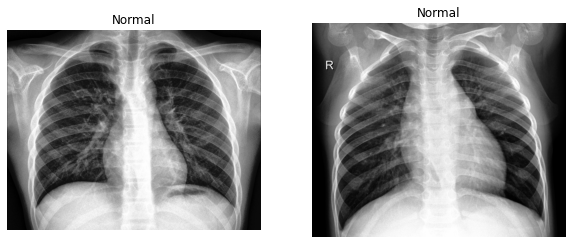

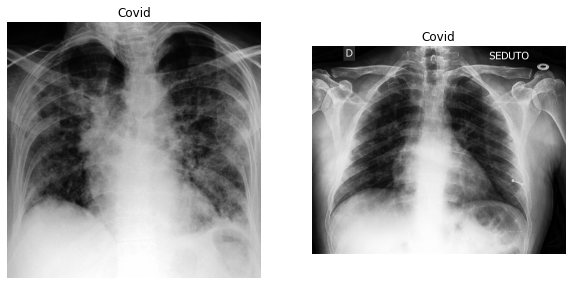

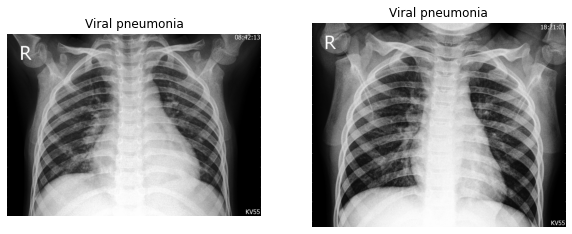

In [3]:

# Path to the directory containing the folders
data_dir = 'C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/train'

# List of subfolders (categories)
categories = ['normal', 'covid', 'viral pneumonia']

# Display 2 random images from each category
for category in categories:
    category_path = os.path.join(data_dir, category)
    image_files = os.listdir(category_path)
    # Randomly select 2 images from the category
    random_images = random.sample(image_files, 2)
    
    # Display the selected images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(category_path, image_file)
        image = mpimg.imread(image_path)
        axs[i].imshow(image)  # Display images as they are
        axs[i].set_title(category.capitalize())
        axs[i].axis('off')
    plt.show()



# DATASET SIZES

In [120]:
# Define the paths to the train and test directories
train_directory = 'C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/train'
test_directory = 'C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test'

# Function to count the number of files in a directory
def count_files(directory):
    count = 0
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            count += 1
    return count

# Count the number of images in each class within the train directory
train_normal_count = count_files(os.path.join(train_directory, 'Normal'))
train_covid_count = count_files(os.path.join(train_directory, 'COVID'))
train_viral_pneumonia_count = count_files(os.path.join(train_directory, 'Viral Pneumonia'))

# Count the number of images in each class within the test directory
test_normal_count = count_files(os.path.join(test_directory, 'Normal'))
test_covid_count = count_files(os.path.join(test_directory, 'COVID'))
test_viral_pneumonia_count = count_files(os.path.join(test_directory, 'Viral Pneumonia'))

# Print the counts
print("TRAINING DATA")
print(f'Train - Normal: {train_normal_count} images')
print(f'Train - COVID: {train_covid_count} images')
print(f'Train - Viral Pneumonia: {train_viral_pneumonia_count} images')

print("TESTING DATA")
print(f'Test - Normal: {test_normal_count} images')
print(f'Test - COVID: {test_covid_count} images')
print(f'Test - Viral Pneumonia: {test_viral_pneumonia_count} images')


TRAINING DATA
Train - Normal: 70 images
Train - COVID: 111 images
Train - Viral Pneumonia: 70 images
TESTING DATA
Test - Normal: 20 images
Test - COVID: 26 images
Test - Viral Pneumonia: 20 images


# PATHS TO THE DATASETS

In [121]:
# Define the path to your dataset folders
train_dataset_path = 'C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/train'
test_dataset_path = 'C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test'

#### DEFINING THE IMAGE HEIGHT AND WIDTH

In [122]:
# Define the image dimensions for resizing
image_width = 128
image_height = 128

# PRE-PROCESSING THE DATA FOR THE 1ST CLASSIFIER

In [214]:
# Function to load and preprocess the images for binary classification (Normal vs. Abnormal)
def load_and_preprocess_data(dataset_path, image_width, image_height):
    images = []
    labels = []

    for class_idx, class_name in enumerate(['Normal', 'COVID', 'Viral Pneumonia']):
        class_path = os.path.join(dataset_path, class_name)
        # Assign class label 0 for 'Normal' and 1 for 'COVID' and 'Viral Pneumonia'
        class_label = 0 if class_name == 'Normal' else 1
        
        for image_filename in os.listdir(class_path):
            image_path = os.path.join(class_path, image_filename)

            # Read and resize the image to grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (image_width, image_height))

            # Normalize pixel values to be between 0 and 1
            image = image.astype('float') / 255.0

            # Append the image and its corresponding label to the lists
            images.append(image)
            labels.append(class_label)

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [215]:
# Load and preprocess the training and test data for binary classification
x_train1, y_train1 = load_and_preprocess_data(train_dataset_path, image_width, image_height)
x_test1, y_test1 = load_and_preprocess_data(test_dataset_path, image_width, image_height)


# ORIGINAL IMAGE VS RESHAPED IMAGE

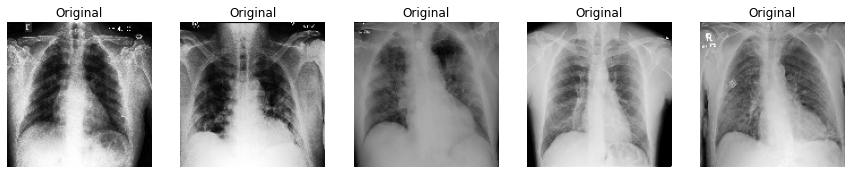

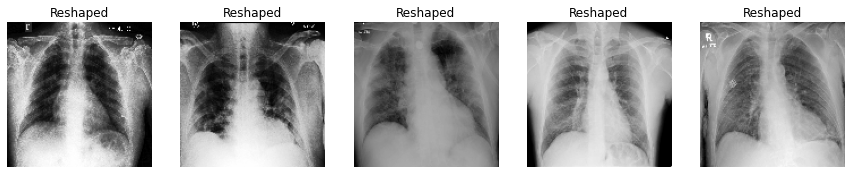

In [159]:
# Choose a few sample images from the training dataset
sample_images = x_train[:5]

# Plot original images
plt.figure(figsize=(15, 3))
for i in range(len(sample_images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i].reshape(image_width, image_height), cmap='gray')
    plt.axis('off')
    plt.title('Original')
plt.show()

# Reshape the sample images
reshaped_images = sample_images.reshape(-1, image_width, image_height, 1)

# Plot reshaped images
plt.figure(figsize=(15, 3))
for i in range(len(reshaped_images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(reshaped_images[i].reshape(image_width, image_height), cmap='gray')
    plt.axis('off')
    plt.title('Reshaped')
plt.show()


To be honest, The reshaped images have the same content as the original images but are represented in a different format suitable for input to the CNN.


# RESHAPING THE IMAGE DATASET

In [216]:
x_train1 = x_train1.reshape(-1, image_width, image_height, 1)
x_test1 = x_test1.reshape(-1, image_width, image_height, 1)

# TRAINING THE DATA

In [222]:
# Build the binary classification model for Normal vs. Abnormal with Dropout regularization
classifier = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.3), 
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Stop training if validation loss doesn't improve for 3 consecutive epochs

# Train the model on both normal and abnormal data with Dropout regularization and Early Stopping
history1 = classifier.fit(x_train1.reshape(-1, image_width, image_height, 1), y_train1, epochs=10, validation_data=(x_test1.reshape(-1, image_width, image_height, 1), y_test1), callbacks=[early_stopping])


Epoch 1/10
8/8 [==============================] - 3s 242ms/step - loss: 1.5653 - accuracy: 0.5578 - val_loss: 0.5327 - val_accuracy: 0.6970
Epoch 2/10
8/8 [==============================] - 2s 207ms/step - loss: 0.4881 - accuracy: 0.7211 - val_loss: 0.4817 - val_accuracy: 0.6970
Epoch 3/10
8/8 [==============================] - 2s 211ms/step - loss: 0.4052 - accuracy: 0.7211 - val_loss: 0.4396 - val_accuracy: 0.6970
Epoch 4/10
8/8 [==============================] - 2s 222ms/step - loss: 0.3530 - accuracy: 0.7450 - val_loss: 0.4229 - val_accuracy: 0.7273
Epoch 5/10
8/8 [==============================] - 2s 215ms/step - loss: 0.3198 - accuracy: 0.8685 - val_loss: 0.3845 - val_accuracy: 0.8182
Epoch 6/10
8/8 [==============================] - 2s 205ms/step - loss: 0.3052 - accuracy: 0.9084 - val_loss: 0.3706 - val_accuracy: 0.8030
Epoch 7/10
8/8 [==============================] - 2s 220ms/step - loss: 0.2809 - accuracy: 0.9243 - val_loss: 0.3827 - val_accuracy: 0.7727
Epoch 8/10
8/8 [====

# EVALUATING THE MODEL WITH TESTING DATA

In [223]:
classifier.evaluate(x_test1, y_test1)

3/3 [==============================] - 0s 24ms/step - loss: 0.3222 - accuracy: 0.9091


[0.32217809557914734, 0.9090909361839294]

# SAVING THE MODEL

In [224]:
classifier.save('my_model_new_new.h5')

# LOADING THE MODEL

In [247]:
# Load the saved model
model1 = load_model('my_model_new_new.h5')

## TESTING WITH A SAMPLE IMAGE

In [230]:
# Define the image dimensions for resizing
image_width = 128
image_height = 128

# Load the image as grayscale
# image = cv2.imread('C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test/Covid/COVID-00037.jpg', cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test/Viral Pneumonia/0118.jpeg', cv2.IMREAD_GRAYSCALE)
image = cv2.imread("C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test/Normal/0101.jpeg", cv2.IMREAD_GRAYSCALE)


# Preprocess the image
image = cv2.resize(image, (image_width, image_height))
image = image.astype('float') / 255.0

# Expand the dimensions of the image to match the format that the model expects (grayscale image has 1 channel)
image = np.expand_dims(image, axis=-1)  # Add the channel axis

# Expand the dimensions to match the batch size and make a prediction
image = np.expand_dims(image, axis=0)  # Add batch size axis
prediction = model1.predict(image)

# Get the predicted class label
# predicted_class_label = np.argmax(prediction)
binary_prediction = (prediction > 0.5).astype(int)

# Print the predicted class label
print('The predicted class label is:', binary_prediction)
print(prediction)


1/1 [==============================] - 0s 70ms/step
The predicted class label is: [[0]]
[[0.49184346]]


# CLASSIFICATION REPORT OF 1ST CLASSIFIER

In [233]:
# After model training
y_pred = model1.predict(x_test1)
y_pred_classes = (y_pred > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test1, y_pred_classes))


3/3 [==============================] - 0s 22ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.90      0.98      0.94        46

    accuracy                           0.91        66
   macro avg       0.92      0.86      0.89        66
weighted avg       0.91      0.91      0.91        66



# CONFUSION MATRIX FOR 1st CLASSIFIER

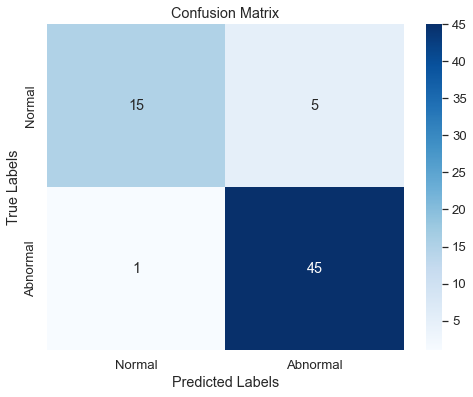

In [235]:
# Assuming y_test contains true labels and y_pred_classes contains predicted labels (0 or 1)
confusion_mtx = confusion_matrix(y_test1, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# PLOTTING GRAPH OF TRAINING AND VALIDATION ACCURACY

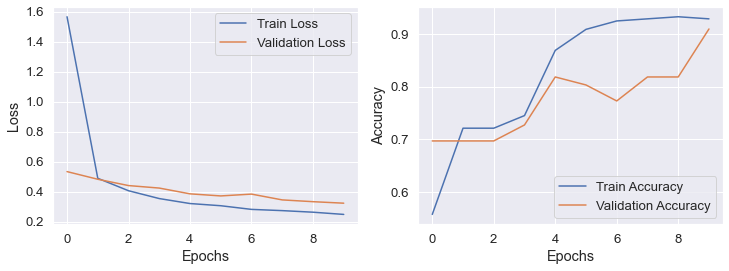

In [236]:
# Extract loss and accuracy values from the history
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']

# Plot loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

# AUROC CURVE FOR 1ST CLASSIFIER

3/3 [==============================] - 0s 17ms/step


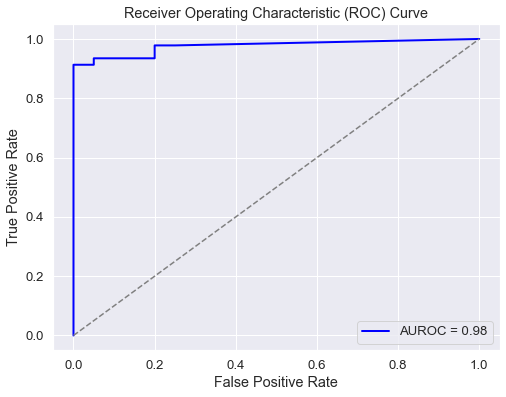

AUROC Score: 0.98


In [242]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming y_test contains true labels and y_pred contains predicted probabilities
y_pred = model1.predict(x_test1)

# Calculate ROC curve and AUROC score
fpr, tpr, thresholds = roc_curve(y_test1, y_pred)
auroc = roc_auc_score(y_test1, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f'AUROC Score: {auroc:.2f}')


In [250]:
model1.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_26 (Flatten)        (None, 127008)            0         
                                                                 
 dropout_26 (Dropout)        (None, 127008)            0         
                                                                 
 dense_52 (Dense)            (None, 32)                4064288   
                                                                 
 dense_53 (Dense)            (None, 1)                 33        
                                                     

# PRE-PROCESSING THE DATA FOR THE 2ND CLASSIFIER

In [198]:
def load_and_preprocess_data(dataset_path, image_width, image_height):
    images = []
    labels = []

    for class_idx, class_name in enumerate(['COVID', 'Viral Pneumonia']):
        class_path = os.path.join(dataset_path, class_name)
        # Assign class label 1 for 'COVID' and 0 for 'Viral Pneumonia'
        class_label = 0 if class_name == 'Viral Pneumonia' else 1
        
        for image_filename in os.listdir(class_path):
            image_path = os.path.join(class_path, image_filename)

            # Read and resize the image to grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (image_width, image_height))

            # Normalize pixel values to be between 0 and 1
            image = image.astype('float') / 255.0

            # Append the image and its corresponding label to the lists
            images.append(image)
            labels.append(class_label)

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [199]:
x_train, y_train = load_and_preprocess_data(train_dataset_path, image_width, image_height)
x_test, y_test = load_and_preprocess_data(test_dataset_path, image_width, image_height)

# RESHAPING THE DATA FOR THE 2ND CLASSIFIER

In [200]:
x_train = x_train.reshape(-1, image_width, image_height, 1)
x_test = x_test.reshape(-1, image_width, image_height, 1)

# ARCHITECTURE OF 2ND CLASSIFIER

In [201]:
# Build the binary classification model for Normal vs. Abnormal with Dropout regularization
classifier2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.3),  # Dropout layer with a dropout rate of 0.5 (50% of the units will be dropped out during training)
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# TRAINING THE MODEL

In [202]:
classifier2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Stop training if validation loss doesn't improve for 3 consecutive epochs

# Train the model on both normal and abnormal data with Dropout regularization and Early Stopping
history2 = classifier2.fit(x_train, y_train, epochs=10, validation_data=(x_train, y_train), callbacks=[early_stopping])


Epoch 1/10
6/6 [==============================] - 2s 216ms/step - loss: 1.6612 - accuracy: 0.7348 - val_loss: 1.5213 - val_accuracy: 0.6133
Epoch 2/10
6/6 [==============================] - 1s 182ms/step - loss: 0.5026 - accuracy: 0.8232 - val_loss: 0.3169 - val_accuracy: 0.8674
Epoch 3/10
6/6 [==============================] - 1s 179ms/step - loss: 0.1046 - accuracy: 0.9503 - val_loss: 0.1980 - val_accuracy: 0.9282
Epoch 4/10
6/6 [==============================] - 1s 180ms/step - loss: 0.1720 - accuracy: 0.9503 - val_loss: 0.0709 - val_accuracy: 0.9779
Epoch 5/10
6/6 [==============================] - 1s 183ms/step - loss: 0.0906 - accuracy: 0.9834 - val_loss: 0.0783 - val_accuracy: 0.9779
Epoch 6/10
6/6 [==============================] - 1s 182ms/step - loss: 0.0733 - accuracy: 0.9779 - val_loss: 0.0605 - val_accuracy: 0.9834
Epoch 7/10
6/6 [==============================] - 1s 187ms/step - loss: 0.0566 - accuracy: 0.9834 - val_loss: 0.0477 - val_accuracy: 0.9834
Epoch 8/10
6/6 [====

# EVALUATING THE MODEL WITH TESTING DATA

In [203]:
classifier2.evaluate(x_test, y_test)

2/2 [==============================] - 0s 20ms/step - loss: 0.1467 - accuracy: 0.9565


[0.146658793091774, 0.95652174949646]

# SAVING THE MODEL

In [204]:
classifier2.save('my_model2_new.h5')

C:\Users\91638\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## TESTING WITH A SAMPLE IMAGE

In [206]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the saved model
model = load_model('my_model2_new.h5')
# covid_viral_model = load_model('my_next_model2.h5')
# Define the image dimensions for resizing
image_width = 128
image_height = 128

# Load the image as grayscale
image = cv2.imread('C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test/Covid/COVID-00037.jpg', cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test/Viral Pneumonia/0118.jpeg', cv2.IMREAD_GRAYSCALE)
# image = cv2.imread("C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test/Normal/0101.jpeg", cv2.IMREAD_GRAYSCALE)


# Preprocess the image
image = cv2.resize(image, (image_width, image_height))
image = image.astype('float') / 255.0

# Expand the dimensions of the image to match the format that the model expects (grayscale image has 1 channel)
image = np.expand_dims(image, axis=-1)  # Add the channel axis

# Expand the dimensions to match the batch size and make a prediction
image = np.expand_dims(image, axis=0)  # Add batch size axis
prediction = model.predict(image)

# Get the predicted class label
# predicted_class_label = np.argmax(prediction)
binary_prediction = (prediction > 0.5).astype(int)

# Print the predicted class label
print('The predicted class label is:', binary_prediction)
print(prediction)


1/1 [==============================] - 0s 48ms/step
The predicted class label is: [[1]]
[[0.99909854]]


# ANALYSIS OF 2ND CLASSIFIER

In [207]:
from sklearn.metrics import classification_report, confusion_matrix

# After model training
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

2/2 [==============================] - 0s 18ms/step
Confusion Matrix:
[[18  2]
 [ 0 26]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.93      1.00      0.96        26

    accuracy                           0.96        46
   macro avg       0.96      0.95      0.96        46
weighted avg       0.96      0.96      0.96        46



# CONFUSION MATRIX FOR THE 2ND CLASSIFIER

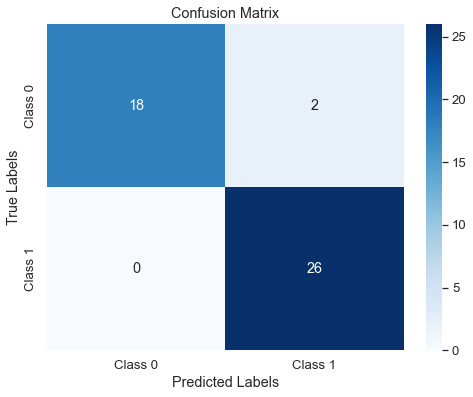

In [208]:


# Assuming y_true contains true labels and y_pred contains predicted labels
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# PLOTTING GRAPH OF TRAINING AND VALIDATION ACCURACY

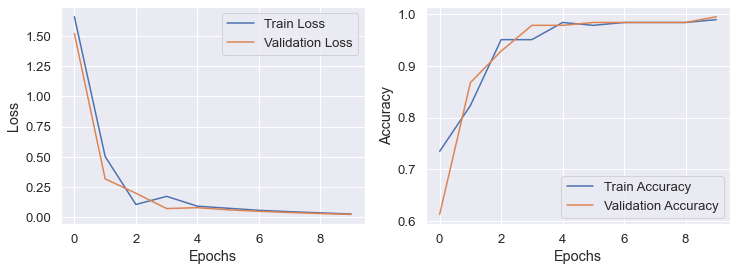

In [209]:
# Extract loss and accuracy values from the history
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

# Plot loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

# AUROC CURVE FOR 2ND CLASSIFIER

2/2 [==============================] - 0s 28ms/step


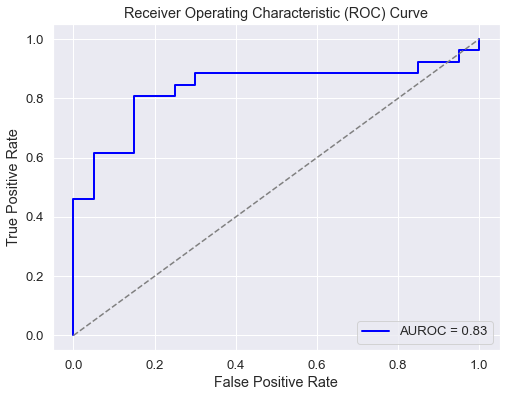

AUROC Score: 0.83


In [243]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming y_test contains true labels and y_pred contains predicted probabilities
y_pred = model.predict(x_test)

# Calculate ROC curve and AUROC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f'AUROC Score: {auroc:.2f}')


In [251]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_26 (Flatten)        (None, 127008)            0         
                                                                 
 dropout_26 (Dropout)        (None, 127008)            0         
                                                                 
 dense_52 (Dense)            (None, 32)                4064288   
                                                                 
 dense_53 (Dense)            (None, 1)                 33        
                                                     

# LOADING MODELS FOR THE TWO LAYER CLASSIFICATION MODEL

In [237]:
normal_abnormal_model = load_model('my_model_new_new.h5')

In [238]:
covid_viral_model = load_model('my_model2_new.h5')

# FINAL (COMBINED) CLASSIFIER STRUCTURE

In [241]:
def preprocess_image(image_path, image_width, image_height):
    # Load and preprocess the image
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_width, image_height))
    image = image.astype('float') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def predict_normal_abnormal(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path, image_width, image_height)
    
    # Predict using the first classifier
    prediction = normal_abnormal_model.predict(processed_image)
    
    # Get the predicted class label
    abnormal_prediction = (prediction > 0.5).astype(int)
    
    # If abnormal, proceed to the second classifier, else return 'Normal'
    if abnormal_prediction == 1:
        return 'Abnormal'
    else:
        return 'Normal'

def predict_covid_viral(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path, image_width, image_height)
    
    # Predict using the second classifier
    prediction = covid_viral_model.predict(processed_image)
    
    # Get the predicted class label
    covid_prediction = (prediction[0][0] > 0.5).astype(int)
    
    # If COVID, return 'COVID', else return 'Viral Pneumonia'
    if covid_prediction == 1:
        return 'COVID'
    else:
        return 'Viral Pneumonia'

def predict_condition(image_path):
    # Predict abnormality using the first classifier
    abnormality_result = predict_normal_abnormal(image_path)
    
    # If abnormal, predict COVID vs. Viral Pneumonia using the second classifier
    if abnormality_result == 'Abnormal':
        virus_result = predict_covid_viral(image_path)
        return abnormality_result, virus_result
    else:
        return abnormality_result, None

# Example usage
# image_path = 'C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test/Viral Pneumonia/0117.jpeg' 
# image_path = 'C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test/Normal/0101.jpeg'  
image_path = 'C:/Users/91638/Desktop/DL PROJECT/Covid19-dataset/Covid19-dataset/test/Covid/COVID-00033.jpg'
abnormality_result, virus_result = predict_condition(image_path)
print("Abnormality Result:", abnormality_result)
print("Virus Result:", virus_result)


1/1 [==============================] - 0s 23ms/step
Abnormality Result: Abnormal
Virus Result: COVID
